In [41]:
import Pkg

#Pkg.add("CSV")
#Pkg.add("Random")

using Zygote
using Flux
using Flux: onehotbatch, onecold, crossentropy
using MLDatasets
#using CUDA
using Statistics
using Plots
using Images
using Colors
using ImageTransformations
using MLUtils
using CSV
using Random
using DataFrames


In [42]:
train_X, train_y = MNIST(split=:train)[:]
test_X, test_y = MNIST(split=:test)[:]

# Normalize the images to the range [0, 1] and convert to Float32
train_X = Float32.(train_X ./ 255.0)
test_X = Float32.(test_X ./ 255.0)

# Reshape the data to match the expected input dimensions (length, channels, batch_size)
train_X = reshape(train_X, size(train_X, 1) * size(train_X, 2), 1, size(train_X, 3))
test_X = reshape(test_X, size(test_X, 1) * size(test_X, 2), 1, size(test_X, 3))

train_X = reshape(train_X, 28, 28, 1, size(train_X, 3))
test_X  = reshape(test_X, 28, 28, 1, size(test_X, 3))

train_y = onehotbatch(train_y, 0:9)  # Convert labels to one-hot encoding
test_y = onehotbatch(test_y, 0:9)

;

In [43]:
conv1 = Conv((3,3), 1=>16, relu, pad=1)
pool1 = MaxPool((2,2))
conv2 = Conv((3,3), 16=>32, relu, pad=1)
pool2 = MaxPool((2,2))
conv3 = Conv((3,3), 32=>64, relu, pad=1)
pool3 = MaxPool((2,2))
conv4 = Conv((3,3), 64=>128, relu, pad=1)
pool4 = MaxPool((2,2))
flatten = Flux.flatten
dense1 = Dense(128, 256, relu)
dense3 = Dense(256, 10)

model = Chain(
    conv1,
    pool1,
    BatchNorm(16),
    conv2,
    pool2,
    BatchNorm(32),
    conv3,
    pool3,
    BatchNorm(64),
    conv4,
    pool4,
    BatchNorm(128),
    flatten,
    dense1,
    dense3,
    softmax
)


Chain(
  Conv((3, 3), 1 => 16, relu, pad=1),   # 160 parameters
  MaxPool((2, 2)),
  BatchNorm(16),                        # 32 parameters, plus 32
  Conv((3, 3), 16 => 32, relu, pad=1),  # 4_640 parameters
  MaxPool((2, 2)),
  BatchNorm(32),                        # 64 parameters, plus 64
  Conv((3, 3), 32 => 64, relu, pad=1),  # 18_496 parameters
  MaxPool((2, 2)),
  BatchNorm(64),                        # 128 parameters, plus 128
  Conv((3, 3), 64 => 128, relu, pad=1),  # 73_856 parameters
  MaxPool((2, 2)),
  BatchNorm(128),                       # 256 parameters, plus 256
  Flux.flatten,
  Dense(128 => 256, relu),              # 33_024 parameters
  Dense(256 => 10),                     # 2_570 parameters
  NNlib.softmax,
)         # Total: 20 trainable arrays, 133_226 parameters,
          # plus 8 non-trainable, 480 parameters, summarysize 524.367 KiB.

In [61]:

opt = ADAM(0.001);

In [62]:
function train_model!(model, train_X, train_Y, opt, epochs, batch_size)
    data_loader = Flux.DataLoader((train_X, train_y), batchsize=batch_size, shuffle=true)
        
    opt_state = Flux.setup(opt, model)  
    total_loss = []

    for epoch in 1:epochs
        epoch_loss = 0
        for (x, y) in data_loader
            gs = Flux.gradient(model -> Flux.Losses.crossentropy(model(x), y), model)[1]  # Compute gradient for loss
            Flux.update!(opt_state, Flux.trainable(model), gs)  # Update model parameters
            epoch_loss += Flux.Losses.crossentropy(model(x), y)  # Add loss for this batch
        end
        println("Epoch $epoch complete, Loss: $(epoch_loss)")
        push!(total_loss, epoch_loss)  # Track total loss over epochs
    end
    return total_loss
end

train_model! (generic function with 1 method)

In [67]:
epochs = 10
batch_size = 64
;

In [68]:
loss_list = train_model!(model, train_X, train_y, opt, epochs, batch_size);

Epoch 1 complete, Loss: 6778.6235
Epoch 2 complete, Loss: 6313.6606
Epoch 3 complete, Loss: 6407.0894
Epoch 4 complete, Loss: 5784.982
Epoch 5 complete, Loss: 4424.253
Epoch 6 complete, Loss: 3729.6323
Epoch 7 complete, Loss: 1729.6567
Epoch 8 complete, Loss: 3152.7139
Epoch 9 complete, Loss: 3017.59
Epoch 10 complete, Loss: 2424.3389


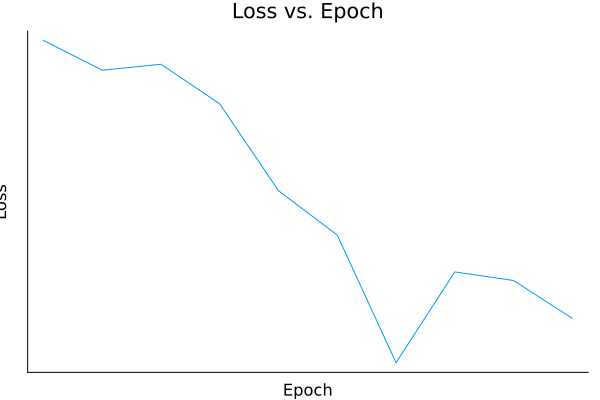

In [69]:
p1 = plot(1:epochs, loss_list, xlabel="Epoch", ylabel="Loss", title="Loss vs. Epoch", legend=false, xticks=false, yticks=false)
display(p1)

In [70]:
#visualize_layers(model, train_x[:, :, :, 1:1])

accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))
println("Test Accuracy: ", accuracy(test_X, test_y))


Test Accuracy: 0.7236
